In [1]:
# Tesseract OCR 설치
!apt-get update
!apt-get install -y tesseract-ocr

# Python용 pytesseract 라이브러리 설치
!pip install pytesseract
!pip install opencv-python-headless

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
!apt-get install -y tesseract-ocr-kor

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

runs/detect/result/crops/0/Enter--2024-11-25_15-48-052.jpg


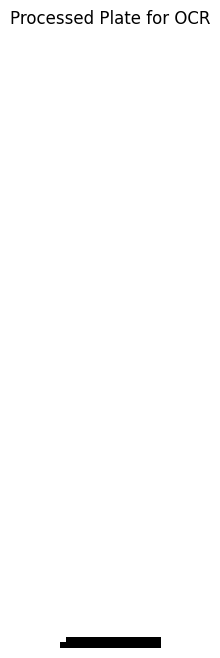

Extracted License Plate Text: 


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'   #기기에 설치된 소프트웨어적인 문제로 인한 임시조치
import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

def extract_license_plate(image_path):
    image = cv2.imread(image_path)

    # 전처리: 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 전처리: 블러링 및 엣지 검출
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blur, 100, 200)

    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    plate = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            pts = approx.reshape(4, 2)

            rect = np.zeros((4, 2), dtype="float32")
            s = pts.sum(axis=1)
            rect[0] = pts[np.argmin(s)]
            rect[2] = pts[np.argmax(s)]

            diff = np.diff(pts, axis=1)
            rect[1] = pts[np.argmin(diff)]
            rect[3] = pts[np.argmax(diff)]

            (tl, tr, br, bl) = rect
            widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
            widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
            maxWidth = max(int(widthA), int(widthB))

            heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
            heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
            maxHeight = max(int(heightA), int(heightB))

            dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]
            ], dtype="float32")

            M = cv2.getPerspectiveTransform(rect, dst)
            plate = cv2.warpPerspective(gray, M, (maxWidth, maxHeight))
            break

    if plate is not None:
        plate = cv2.resize(plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        _, plate_binary = cv2.threshold(plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        text = pytesseract.image_to_string(plate_binary, lang='kor+eng', config='--psm 6 preserve_interword_spaces')
        #chars = pytesseract.image_to_string(plate_binary, lang='kor', config='--psm 7 --oem 3')
        plt.figure(figsize=(10, 8))
        plt.imshow(plate_binary, cmap='gray')
        plt.title("Processed Plate for OCR")
        plt.axis("off")
        plt.show()

        return text.strip()
    else:
        return "No plate detected"
    
folder_path = 'runs/detect/result/crops/0/'

# each_file_path_and_gen_time: 각 file의 경로와, 생성 시간을 저장함
each_file_path_and_gen_time = []
for each_file_name in os.listdir(folder_path):
    # getctime: 입력받은 경로에 대한 생성 시간을 리턴
    each_file_path = folder_path + each_file_name
    each_file_gen_time = os.path.getctime(each_file_path)
    each_file_path_and_gen_time.append(
        (each_file_path, each_file_gen_time)
    )

# 가장 생성시각이 큰(가장 최근인) 파일을 리턴 
most_recent_file = max(each_file_path_and_gen_time, key=lambda x: x[1])[0]
print(most_recent_file)

extracted_text = extract_license_plate(most_recent_file)
print("Extracted License Plate Text:", extracted_text)